<div style="font-size:20px;">
Importing Data/Libraries and taking first glance
</div>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
import re

df = pd.read_csv('./ufo_sighting_data.csv')
df.head(10)

/var/folders/zz/mssdg1lx09z8g0flcjnd5b9r0000gn/T/ipykernel_47598/579896928.py:9: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./ufo_sighting_data.csv')


,Date_time,city,state/province,country,UFO_shape,length_of_encounter_seconds,described_duration_of_encounter,description,date_documented,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595,-82.188889
6,10/10/1965 21:00,penarth (uk/wales),NaN,gb,circle,180,about 3 mins,penarth uk circle 3mins stayed 30ft above m...,2/14/2006,51.434722,-3.180000
7,10/10/1965 23:45,norwalk,ct,us,disk,1200,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.1175,-73.408333
8,10/10/1966 20:00,pell city,al,us,disk,180,3 minutes,Strobe Lighted disk shape object observed clos...,3/19/2009,33.5861111,-86.286111
9,10/10/1966 21:00,live oak,fl,us,disk,120,several minutes,Saucer zaps energy from powerline as my pregna...,5/11/2005,30.2947222,-82.984167


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Date_time                        80332 non-null  object 
 1   city                             80332 non-null  object 
 2   state/province                   74535 non-null  object 
 3   country                          70662 non-null  object 
 4   UFO_shape                        78400 non-null  object 
 5   length_of_encounter_seconds      80332 non-null  object 
 6   described_duration_of_encounter  80332 non-null  object 
 7   description                      80317 non-null  object 
 8   date_documented                  80332 non-null  object 
 9   latitude                         80332 non-null  object 
 10  longitude                        80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


<div style="font-size:20px;">
Check For Duplicates
</div>

In [5]:
df.duplicated().sum().any()

np.False_

<div style="font-size:20px;">
Format column names and drop columns not needed
</div>

In [6]:
#drop described_duration_of_encounter column
df = df.drop(columns=['described_duration_of_encounter', 'date_documented'])

#format column values capitalization
df['city'] = df['city'].str.title()
df['state/province'] = df['state/province'].str.upper()
df['country'] = df['country'].str.upper()
df['UFO_shape'] = df['UFO_shape'].str.title()

<div style="font-size:20px;">
Cleaning Date_time column and add time-related columns
</div>

In [7]:
df = df.rename(columns={'Date_time': 'date_time'})

#fix case where hour is 24 (pandas can only handle 0-23)
df['date_time'] = df['date_time'].str.replace('24:00', '00:00')
df['date_time'] = pd.to_datetime(df['date_time'], format='%m/%d/%Y %H:%M')

#add year, month, hour columns
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['hour'] = df['date_time'].dt.hour

# Apply the mapping function to create a 'Season' column
def map_to_season(timestamp):
    month = timestamp.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'
        
df['season'] = df['date_time'].apply(map_to_season)
df['season'].value_counts()

season
Summer    26308
Autumn    21735
Spring    16270
Winter    16019
Name: count, dtype: int64

<div style="font-size:20px;">
Cleaning length_of_encounter_seconds column
</div>

In [8]:
#some rows in length_of_encounter_seconds contain symbols
invalid_values = df.loc[pd.to_numeric(df['length_of_encounter_seconds'], errors='coerce').isna(), 'length_of_encounter_seconds'].unique()
print('Invalid values:', invalid_values)

#replace them with empty space to allow subsequent conversion to numeric
def remove_backtick(x):
    if isinstance(x, str):
        return x.replace('`', '')
    else:
        return x
df['length_of_encounter_seconds'] = df['length_of_encounter_seconds'].apply(remove_backtick)

Invalid values: ['2`' '8`' '0.5`']


In [9]:
#format to integer
#convert to numeric first, then use round to avoid floats, finally use int64 to avoid non finite values
df['length_of_encounter_seconds'] = pd.to_numeric(df['length_of_encounter_seconds'], errors='coerce').round().astype('Int64')

In [10]:
# check for illogical max/min values that should be clipped
# There are second values that are equal to 73 days 
df['length_of_encounter_seconds'].sort_values(ascending=False).head(10)

559      97836000
53384    82800000
74660    66276000
64390    52623200
38261    52623200
69215    52623200
52709    25248000
71172    10526400
6991     10526400
30596    10526400
Name: length_of_encounter_seconds, dtype: Int64

In [11]:
#.clip(lower, upper) sets lower and upper bounds that value allows.
# now the maximum duration allowed is 14400 seconds, or 4 hours (more logical)
for col in df.select_dtypes(include='Int64').columns:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.90)
    df[col] = df[col].clip(lower=lower, upper=upper)

df['length_of_encounter_seconds'].describe()

count       80332.0
mean     462.477879
std      596.830308
min             2.0
25%            30.0
50%           180.0
75%           600.0
max          1800.0
Name: length_of_encounter_seconds, dtype: Float64

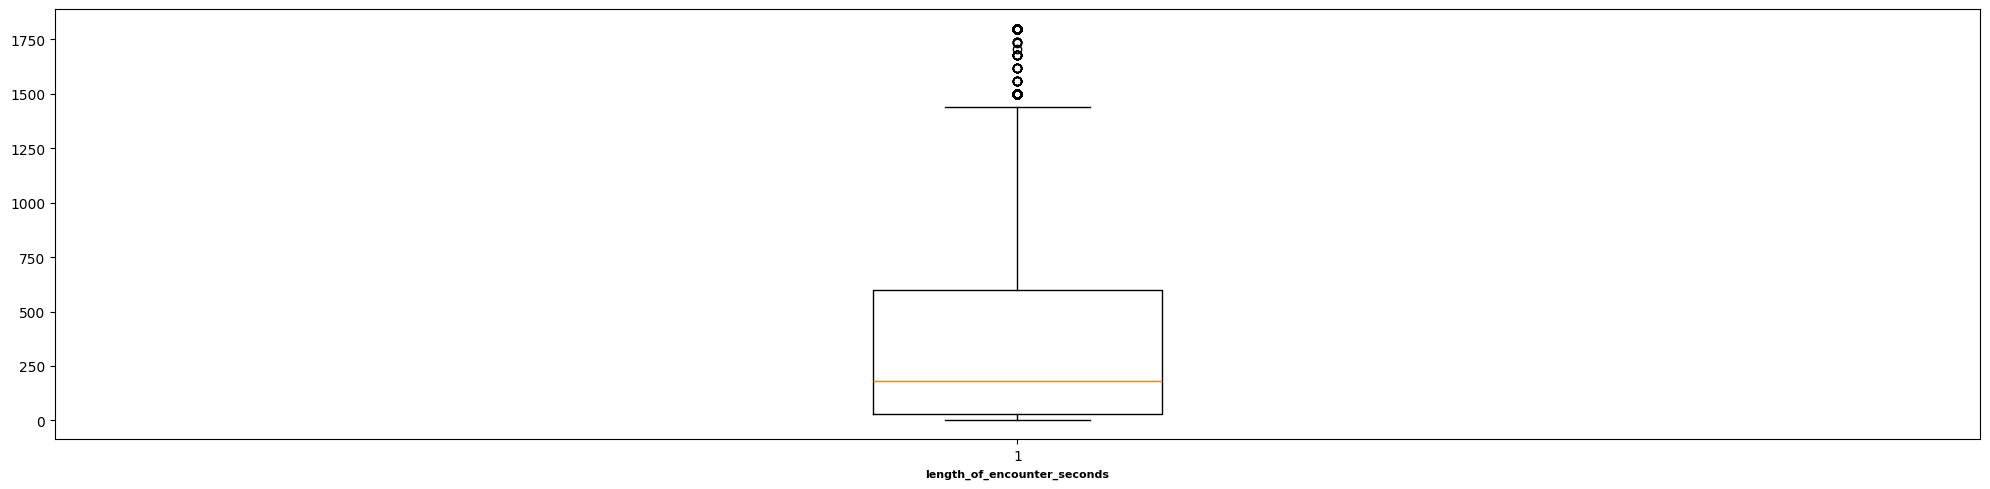

In [12]:
#plot distribution of length_of_encounter_seconds
plt.figure(figsize=(20,5))
plt.boxplot(df['length_of_encounter_seconds'].dropna())
plt.xlabel('length_of_encounter_seconds',fontsize=8, weight='bold')
plt.tight_layout()


<div style="font-size:20px;">
Cleaning long and lat columns
</div>

In [13]:
# Remove all characters except digits and dots
df['latitude'] = df['latitude'].astype(str).str.replace(r'[^0-9.-]', '', regex=True)
df['longitude'] = df['longitude'].astype(str).str.replace(r'[^0-9.-]', '', regex=True)

# Convert to numeric, coercing errors to NaN (in case empty strings remain)
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

In [14]:
#check lattitude within range of -90 to 90
df['latitude'].describe()

count    80332.000000
mean        38.124416
std         10.469585
min        -82.862752
25%         34.134722
50%         39.411111
75%         42.788333
max         72.700000
Name: latitude, dtype: float64

In [15]:
#check longitude within range of -180 to 180
df['longitude'].describe()

count    80332.000000
mean       -86.772885
std         39.697205
min       -176.658056
25%       -112.073333
50%        -87.903611
75%        -78.755000
max        178.441900
Name: longitude, dtype: float64

<div style="font-size:20px;">
Clean the country column and use only America/Canada data
</div>

In [ ]:
# US State 2-letter abbreviations
us_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
# Canada Province/Territory 2-letter abbreviations
canada_provinces = ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'NT', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT']

# Update country column based on state/province values
def assign_country(row):
    sp = row['state/province']
    if sp in us_states:
        return 'US'
    elif sp in canada_provinces:
        return 'CA'
    else:
        return row['country']  # keep original if no match

df['country'] = df.apply(assign_country, axis=1)

#rows where the country is either 'US' or 'CA'.
df = df[(df['country'] == 'US') | (df['country'] == 'CA')]

<div style="font-size:20px;">
Clean the UFO_shape column
</div>

In [17]:
df['UFO_shape'].value_counts(dropna=False)

UFO_shape
Light        15415
Triangle      7389
Circle        6938
Fireball      5818
Unknown       5235
Other         5172
Sphere        4969
Disk          4776
Oval          3442
Formation     2276
Cigar         1890
Changing      1814
NaN           1790
Flash         1242
Rectangle     1216
Cylinder      1188
Diamond       1072
Chevron        911
Egg            676
Teardrop       673
Cone           276
Cross          212
Delta            7
Round            2
Crescent         2
Pyramid          1
Flare            1
Hexagon          1
Dome             1
Changed          1
Name: count, dtype: int64

In [18]:
#check UFO_shape values, fill Nan values into 'unknown'
df['UFO_shape'] = df['UFO_shape'].fillna('Unknown')

<div style="font-size:20px;">
Final Check and export
</div>

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74406 entries, 0 to 80331
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date_time                    74406 non-null  datetime64[ns]
 1   city                         74406 non-null  object        
 2   state/province               74391 non-null  object        
 3   country                      74406 non-null  object        
 4   UFO_shape                    74406 non-null  object        
 5   length_of_encounter_seconds  74406 non-null  Int64         
 6   description                  74393 non-null  object        
 7   latitude                     74406 non-null  float64       
 8   longitude                    74406 non-null  float64       
 9   year                         74406 non-null  int32         
 10  month                        74406 non-null  int32         
 11  hour                         74406 non-null  i

In [ ]:
#reset index to match the number of rows (because we dropped some rows during cleaning)
df = df.reset_index(drop=True)
#rename index to create a primary key for the table
df.index.name = 'sighting_id'
df.to_csv('ufo_sighting_data_cleaned.csv')
df

,date_time,city,state/province,country,UFO_shape,length_of_encounter_seconds,description,latitude,longitude,year,month,hour,season
sighting_id,,,,,,,,,,,,,
0,1949-10-10 20:30:00,San Marcos,TX,US,Cylinder,1800,This event took place in early fall around 194...,29.883056,-97.941111,1949,10,20,Autumn
1,1949-10-10 21:00:00,Lackland Afb,TX,US,Light,1800,1949 Lackland AFB&#44 TX. Lights racing acros...,29.384210,-98.581082,1949,10,21,Autumn
2,1956-10-10 21:00:00,Edna,TX,US,Circle,20,My older brother and twin sister were leaving ...,28.978333,-96.645833,1956,10,21,Autumn
3,1960-10-10 20:00:00,Kaneohe,HI,US,Light,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.418056,-157.803611,1960,10,20,Autumn
4,1961-10-10 19:00:00,Bristol,TN,US,Sphere,300,My father is now 89 my brother 52 the girl wit...,36.595000,-82.188889,1961,10,19,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74401,2013-09-09 21:15:00,Nashville,TN,US,Light,600,Round from the distance/slowly changing colors...,36.165833,-86.784444,2013,9,21,Autumn
74402,2013-09-09 22:00:00,Boise,ID,US,Circle,1200,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,43.613611,-116.202500,2013,9,22,Autumn
74403,2013-09-09 22:00:00,Napa,CA,US,Other,1200,Napa UFO&#44,38.297222,-122.284444,2013,9,22,Autumn


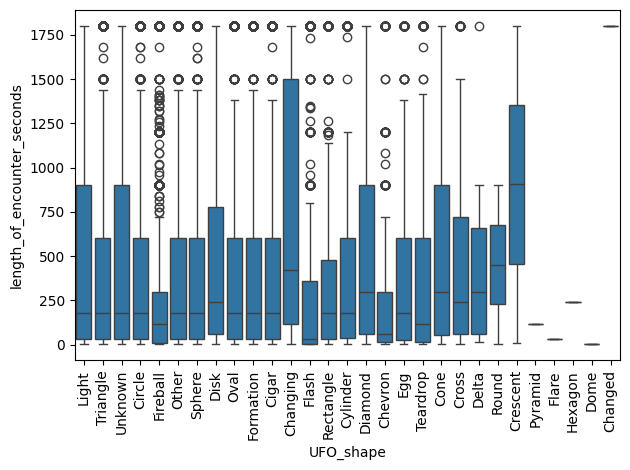

In [21]:
import seaborn as sns

# Boxplot of duration by UFO shape
shape_order = df['UFO_shape'].value_counts().index
sns.boxplot(x='UFO_shape', y='length_of_encounter_seconds', data=df, order=shape_order)
plt.xticks(rotation=90)
plt.tight_layout()  
plt.show()